In [1]:
# print(model.model.transformer_module.decoder)
# environment is bizon_py39
# print(model.class_predictor)
# - Get the linear layer with the class predictor 

import torch 
import random
from datasets import concatenate_datasets, load_dataset
from torch.utils.data import Dataset 
from datasets import load_dataset
import cv2
from torch.utils.data import DataLoader
from huggingface_hub import hf_hub_download
import json
from PIL import Image
import numpy as np
import os 
import torchvision as torchvision
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
import torchvision as torchvision
import albumentations as A
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/chia/anaconda3/envs/bizon_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
torch.cuda.current_device()

0

## New Dataset

In [2]:
class NormalizeTransform(object):
    def __call__(self, img):
        img = img / 255.0
        return img
    
train_image_dir = '/media/data_16T/chloe/try/Dataset/urbanruraltrainimages'
train_mask_dir = '/media/data_16T/chloe/try/Dataset/urbanruraltrainmasks'
val_image_dir = '/media/data_16T/chloe/try/Dataset/urbanruralvalimages'
val_mask_dir = '/media/data_16T/chloe/try/Dataset/urbanruralvalmasks'

fake_image_dir = '/media/data_16T/chloe/try/onedataset'
fake_mask_dir = '/media/data_16T/chloe/try/fakemaskdataset'

import torchvision.transforms as transforms

# train_transform expects an img. train_transform(img)
train_transform = transforms.Compose([
    # transforms.RandomCrop(512),
    # you are random cropping the mask as well, which causes different numbers of segmentation maps. this causes it to randomly cut out some
    transforms.RandomRotation(90),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
    
])

image_transform = transforms.Compose([
    # transforms.RandomRotation(90),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomCrop(512), # added this in august 12th 
    transforms.ToTensor(),
    NormalizeTransform()
])

test_transform = transforms.Compose([
    # transforms.RandomCrop(512),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])

])

image_test_transform = transforms.Compose([
    # transforms.RandomCrop(512), # added this in august 12th 
    NormalizeTransform()
])

In [3]:
repo_id = f"chloechia/loveda"
filename = "id2label.json"
#id2label is in BGR format. 
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'Ignore', 1: 'Background', 2: 'Building', 3: 'Road', 4: 'Water', 5: 'Barren', 6: 'Forest', 7: 'Agricultural'}


In [6]:
# from torchview import draw_graph

# model_graph = draw_graph(model, input_size=(1, 3, 255, 255),
#                         save_graph=True)
# viz = model_graph.visual_graph

In [4]:
from PIL import Image
import cv2 as cv2 
from transformers import Mask2FormerImageProcessor, Mask2FormerConfig, Mask2FormerForUniversalSegmentation, AutoImageProcessor

CONFIG = "facebook/mask2former-swin-large-cityscapes-semantic"
processor = Mask2FormerImageProcessor(ignore_index=0,reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
# model = Mask2FormerForUniversalSegmentation(label2id=id2label, ignore_mismatched_sizes=True)


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# from torchview import draw_graph

# model_graph = draw_graph(model, input_size=(1, 3, 255, 255),
#                         save_graph=True)
# viz = model_graph.visual_graph
# viz

In [9]:
# the reason why we get the error is because segmentation_maps is marked as None. so some of the segmentation maps are just zero 
# the first time i ran the batch iter loop, the segmentation_map stops when the unique values are just [0]. the segmetnation map only has values of 0. it is definitely not empty. 

In [5]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

/home/chia/anaconda3/envs/bizon_py39/lib/python3.9/site-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
def custom_preprocessor(images, segmentation_maps=None, return_tensors="pt"):
    # Check if any segmentation map contains [0]
    unique_numbers = np.unique(segmentation_maps[0])
    if np.array_equal([0], unique_numbers):
        # Skip processing this batch if any segmentation map contains [0]
        print("skipped array 0")
        return None 
    else: 
        # Perform default preprocessing using the original preprocessor
        batch = preprocessor(images, segmentation_maps=segmentation_maps, return_tensors=return_tensors)
        return batch

def custom_collate_fn_2(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    
    # the batch["mask_label"] is a list of tensors 
    processed_batch = custom_preprocessor(
        images, 
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    if processed_batch is None:
        # Skip processing this batch if any segmentation map contains [0]
        return None
    else: 
        processed_batch["original_images"] = inputs[2]
        processed_batch["original_segmentation_maps"] = inputs[3]
        return processed_batch
    # else:
    #     unique_numbers_2 = np.unique(segmentation_maps[0])
    #     if np.array_equal([0], unique_numbers_2):
    #         print("skipped array 0")
    #         pass
    #     # Continue with processing the batch as it doesn't contain [0]
    #     else: 
    #         print(np.unique(segmentation_maps[0]))
    #         processed_batch["original_images"] = inputs[2]
    #         processed_batch["original_segmentation_maps"] = inputs[3]
    #         return processed_batch


In [12]:
# def custom_collate_fn(batch):
#     inputs = list(zip(*batch))
#     images = inputs[0]
#     segmentation_maps = inputs[1]
#     result = np.array_equal([0], segmentation_maps[0])
#     # if np.array_equal([0], segmentation_maps):
#     #     # Skip processing this batch if it contains [0]
#     #     return None 
#     # else: 
#     #     return "Fine"

#     print(np.unique(segmentation_maps[0]))
#     # print(segmentation_maps)
#     # the batch["mask_label"] is a list of tensors 
#     batch = preprocessor(
#         images, 
#         segmentation_maps=segmentation_maps,
#         return_tensors="pt",
#     )

#     # print("after")
#     # print(type(segmentation_maps))    
#     batch["original_images"] = inputs[2]
#     batch["original_segmentation_maps"] = inputs[3]
#     return batch

In [7]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset

# class ApplyTransforms(object):
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, mask):
#         # Apply the same random transformations to both image and mask
#         seed = torch.randint(0, 1000000, (1,)).item()
#         random_transforms = transforms.RandomApply(self.transforms, p=1.0)
#         transformed_image = random_transforms(image, seed)
#         transformed_mask = random_transforms(mask, seed)

#         return transformed_image, transformed_mask
        
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_transform = image_transform
        self.image_files = os.listdir(image_dir)
        self.mask_files = os.listdir(mask_dir)
        self.num_files = len(self.image_files)
    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_files[index])
        mask_path = os.path.join(self.mask_dir, self.mask_files[index])
        
        original_image = Image.open(image_path).convert('RGB')
        original_mask = Image.open(mask_path)
        
        if self.transform is not None:
            seed = np.random.randint(10000)
            random.seed(seed)
            image = self.transform(original_image)
            random.seed(seed)
            mask = self.transform(original_mask)
            # image = self.transform(original_image)
            # mask = self.transform(original_mask)
            mask = np.squeeze(mask)
            
        if self.image_transform is not None:
            image = self.image_transform(image)

        # return image, mask, original_image, original_mask
        return np.array(image), np.array(mask), np.array(original_image), np.array(original_mask)
# SEGMENTATION MAPS BEFORE AND AFTER THE PROCESSING IS THE SAME 
# # <class 'tuple'>
# (512, 512)
# [0 1 2 4 6]
# after
# <class 'tuple'>
# (512, 512)
# [0 1 2 4 6]

In [14]:
# class OneDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None, image_transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.image_transform = image_transform
#         self.image_files = os.listdir(image_dir)
#         self.mask_files = os.listdir(mask_dir)
#         self.num_files = len(self.image_files)
#     def __len__(self):
#         return self.num_files

#     def __getitem__(self, index):
#         image_path = os.path.join(self.image_dir, self.image_files[index])
#         mask_path = os.path.join(self.mask_dir, self.mask_files[index])
        
#         original_image = Image.open(image_path).convert('RGB')
#         original_mask = Image.open(mask_path)
        
#         if self.transform is not None:
#             seed = np.random.randint(10000)
#             random.seed(seed)
#             image = self.transform(original_image)
#             random.seed(seed)
#             mask = self.transform(original_mask)
#             # image = self.transform(original_image)
#             # mask = self.transform(original_mask)
#             mask = np.squeeze(mask)
            
#         if self.image_transform is not None:
#             image = self.image_transform(image)

#         # return image, mask, original_image, original_mask
#         print("correct file path")
#         print(self.image_files[index])
#         return np.array(image), np.array(mask), np.array(original_image), np.array(original_mask)

In [15]:
# fake_dataset = OneDataset(train_image_dir, fake_mask_dir, transform=train_transform, image_transform=image_transform)
# fake_dataloader = DataLoader(fake_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn_2)

In [8]:
train_dataset = CustomSegmentationDataset(train_image_dir, train_mask_dir, transform=train_transform, image_transform=image_transform)
val_dataset = CustomSegmentationDataset(val_image_dir, val_mask_dir, transform=test_transform, image_transform=image_test_transform)    

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn_2)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn_2)

In [41]:
id2label

{0: 'Ignore',
 1: 'Background',
 2: 'Building',
 3: 'Road',
 4: 'Water',
 5: 'Barren',
 6: 'Forest',
 7: 'Agricultural'}

In [18]:
# for idx, batch in enumerate(fake_dataloader):
#     if idx < 1500: 
#         print("ID:", idx)
#         # for k,v in batch.items():
#         #     if isinstance(v, torch.Tensor):
#         #         print(k,v.shape)
#         #     else:
#         #         print(k,v[0].shape)

In [19]:
# for idx, batch in enumerate(fake_dataloader):
#     print("ID:", idx)
#     # for k,v in batch.items():
#     #     if isinstance(v, torch.Tensor):
#     #         print(k,v.shape)
#     #     else:
#     #         print(k,v[0].shape)
#     break

In [10]:
import evaluate

metric = evaluate.load("mean_iou")

## Inference 

In [11]:
def color_palette(): 
    return [[0, 0, 0], [255, 255, 255],
    [255, 0, 0], [255, 255, 0],
    [0, 0, 255],
    [159, 129, 183],
    [0, 255, 0],
    [255, 195, 128]]

palette = color_palette() 

In [12]:
# Visualize the val images original image and the mask image but only for the trees
from PIL import Image

# Replace 'path_to_your_mask.png' with the actual path of your segmentation mask PNG file
mask_path = '/media/data_16T/chloe/try/Dataset/urbanruralvalmasks/2522.png'
# Load the PNG image
mask_image = Image.open(mask_path)

# Display the image
mask_array = np.array(mask_image)
mask_array

array([[4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       ...,
       [3, 3, 3, ..., 7, 7, 7],
       [3, 3, 3, ..., 7, 7, 7],
       [3, 3, 3, ..., 7, 7, 7]], dtype=uint8)

In [ ]:
# # creates a blank mask2former model with no pretrained weights. 
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# config = Mask2FormerConfig()
# model = Mask2FormerForUniversalSegmentation(config=config)
# model.load_state_dict(torch.load("/media/data_16T/chloe/try/modelaugust8.pt", map_location=device))

In [23]:
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
# Other necessary imports and dataset loading

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.load_state_dict(torch.load("/media/data_16T/chloe/try/modelaugust8.pt", map_location=device))

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0


<All keys matched successfully>

In [35]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 1024, 1024])
pixel_mask torch.Size([1, 1024, 1024])
mask_labels torch.Size([6, 1024, 1024])
class_labels torch.Size([6])
original_images (1024, 1024, 3)
original_segmentation_maps (1024, 1024)


In [54]:
# model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("/media/data_16T/chloe/try/modelaugust10.pt", map_location=device))

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## Output of Inference using my model pt file.

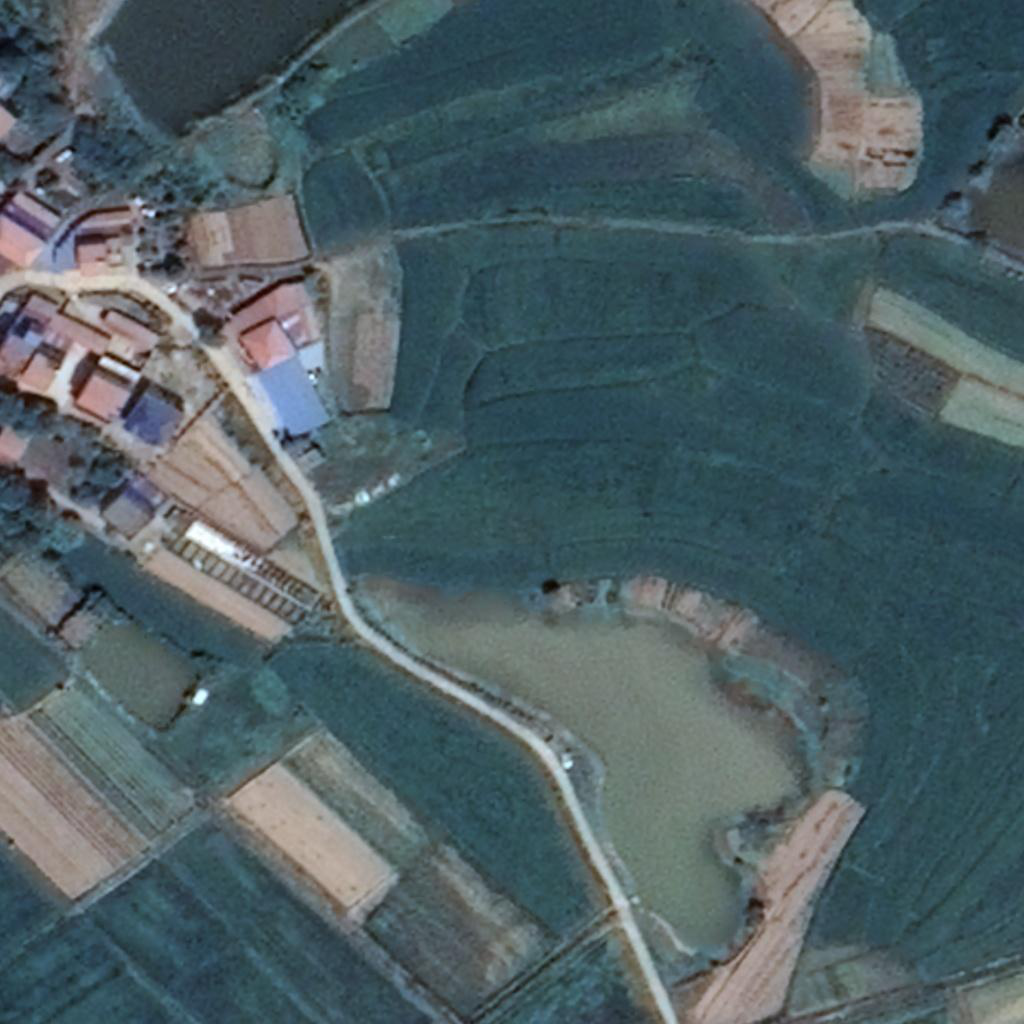

In [57]:
# Show original image
with torch.no_grad():
    outputs = model(batch["pixel_values"].to(device))

original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
ground_truth_segmentation_maps = batch["original_segmentation_maps"]

metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
image = batch["original_images"][0]
# this 0 index means the image, not the number of images. 
Image.fromarray(image)

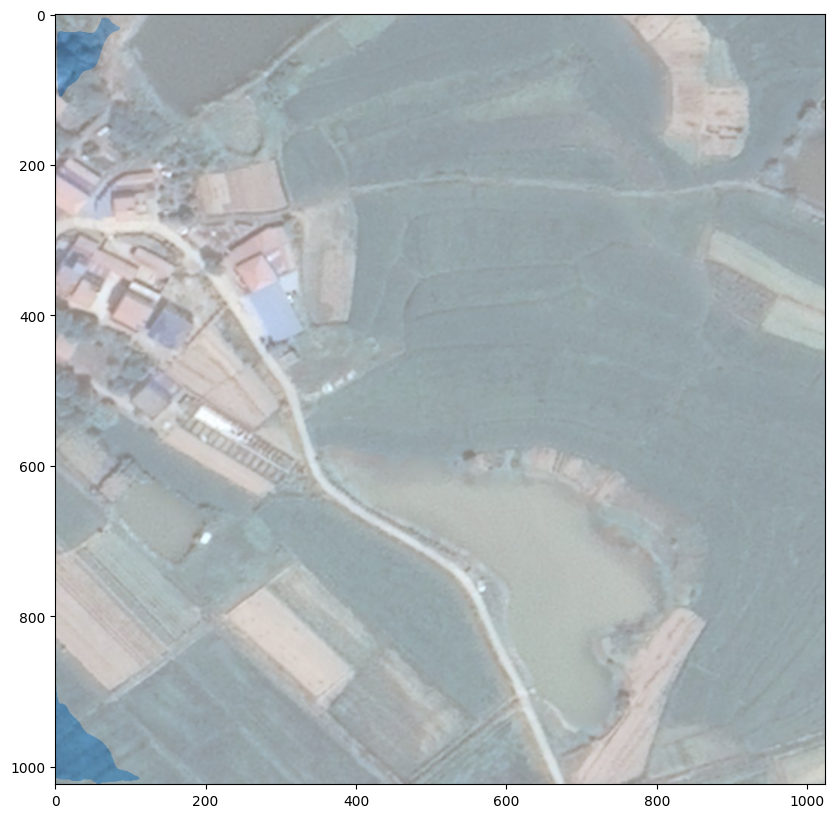

In [58]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

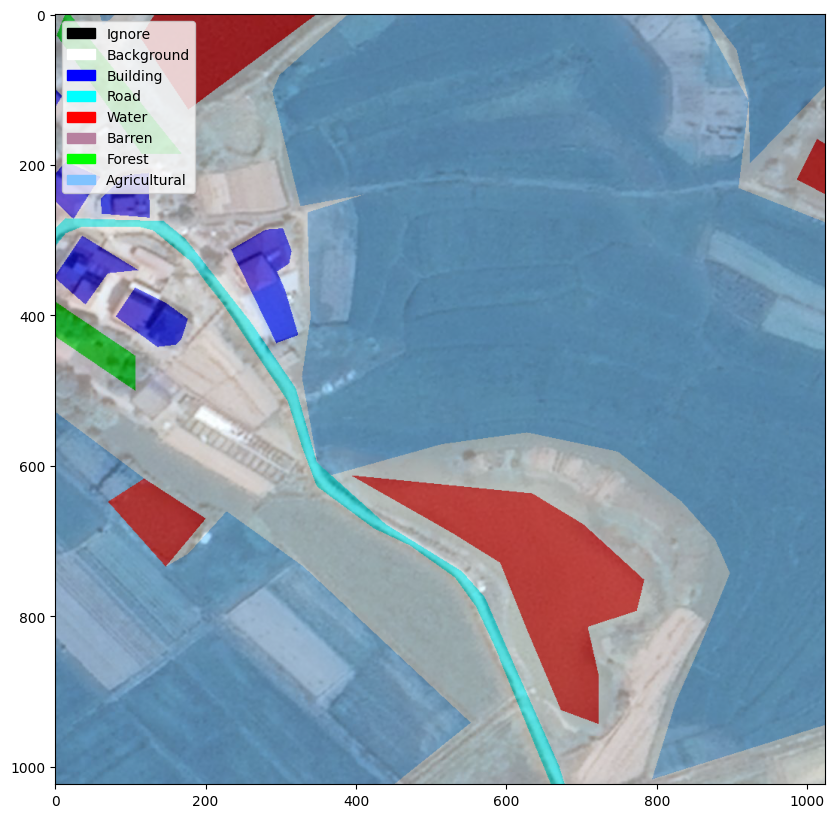

In [46]:
# Ground truth from LoveDA Dataset
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][0]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)
plt.figure(figsize=(15, 10))
plt.imshow(img)

patches = [plt.Rectangle((0,0),1,1, color=np.array(color[::-1])/255.) for color in palette]  # Convert BGR to RGB for legend
labels = [id2label[i] for i in range(len(palette))]
plt.legend(patches, labels, loc='upper left', prop={'size': 10})


plt.show()

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0
<class 'transformers.image_processing_utils.BatchFeature'>
ground truth segmentation map
[[1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
<class 'transformers.image_processing_utils.BatchFeature'>
ground truth segmentation map
[[4 4 4 ... 7 7 7]
 [4 4 4 ... 7 7 7]
 [4 4 4 ... 7 7 7]
 ...
 [1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]]
<class 'transformers.image_processing_utils.BatchFeature'>
ground truth segmentation map
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [6 6 6 ... 1 1 1]
 [6 6 6 ... 1 1 1]
 [6 6 6 ... 1 1 1]]
<class 'transformers.image_processing_utils.BatchFeature'>
ground truth segmentation map
[[7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]
 ...
 [7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]
 [7 7 7 ... 0 0 0]]
<class 'transformers.image_processing_utils.BatchFeature'>
ground truth segmentation map
[[6 6 6 ... 1 1 1]
 [6 6 6 ... 1 1 1]
 [6 6 6 ... 1 1 1]
 ...
 [1 1 

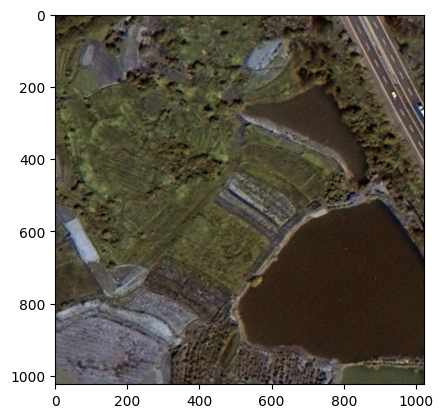

In [13]:
# this shoudl show side by side the outputted image and the ground truth . we only want to hold the model on the pixel values
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
# Other necessary imports and dataset loading

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.load_state_dict(torch.load("/media/data_16T/chloe/try/modelaugust8.pt", map_location=device))
model.eval()

for idx, batch in enumerate(val_dataloader):
  if idx > 4:d
    break
  print(type(batch))
  # this is more efficient code than while idx !=2: pass, because the while loop would constantly check the condition in each iteration 
  pixel_values = batch["pixel_values"].to(device)
  # Forward pass
  with torch.no_grad():
    outputs = model(pixel_values=pixel_values) # forward pass 
  # get original images
  original_images = batch["original_images"]
  original_image_no_tuple = original_images[0].astype(np.uint8)
  # original_images[0] is [1024,1024,3]
  original_image_rgb = original_image_no_tuple[..., ::-1]
  plt.imshow(original_image_rgb)
  target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
  # predict segmentation maps
  predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs,
                                                                                target_sizes=target_sizes)
  # get ground truth segmentation maps
  ground_truth_segmentation_maps = batch["original_segmentation_maps"]
  # ground truth segmentation maps is a tuple, where the segmentation map is reached by [0]
  # ground truth segmentation maps[0] is np array. matches
  print("ground truth segmentation map")
  print(ground_truth_segmentation_maps[0])
  # metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
  # print(idx)
  # print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])
  # # Visualization 
  # segmentation_map = predicted_segmentation_maps[0].cpu().numpy()
  # # segmentation map is 1024 by 1024

  # color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
  # # color_segmentation_map is 1024 by 1024 by 3 
  # for label, color in enumerate(palette):
  #   color_segmentation_map[segmentation_map == label, :] = color
  # ground_truth_color_seg = color_segmentation_map[..., ::-1]
  # tensor_to_pil = transforms.ToPILImage() 
  # pixel_values = np.squeeze(pixel_values,axis=0)
  # pixel_values = tensor_to_pil(pixel_values)
  # plt.imshow(pixel_values)
  # plt.show()
  # img = np.array(pixel_values) * 0.5 + ground_truth_color_seg * 0.5
  # img = img.astype(np.uint8)
  # plt.figure(figsize=(15, 10))
  # plt.imshow(img)
  # plt.show()

# NOTE this metric outputs a dict that also includes the mIoU per category as keys
# so if you're interested, feel free to prcint them as well

# # 20 minutes for 230 

## Inference with Visualization 

In [23]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))
     

pixel_values torch.Size([1, 3, 1024, 1024])
pixel_mask torch.Size([1, 1024, 1024])
mask_labels 1
class_labels 1
original_images 1
original_segmentation_maps 1


# Dataloading

# Image Segmentation Class

In [25]:
def color_palette():
    return [[0,0,0], [255, 255, 255], [255,0,0], [255,255,0], [0,0,255], [159,129,183], [0,255,0], [255,195, 128]]

palette = color_palette()
palette

[[0, 0, 0],
 [255, 255, 255],
 [255, 0, 0],
 [255, 255, 0],
 [0, 0, 255],
 [159, 129, 183],
 [0, 255, 0],
 [255, 195, 128]]

## Change the last Fully Connected Layer 

In [ ]:
from torch import nn 
fc = nn.Linear(in_features=256, out_features=8)
model.class_predictor = fc
model.class_predictor
print(model)

In [22]:
print(model.model._modules.keys())

odict_keys(['pixel_level_module', 'transformer_module'])


In [28]:
print(model.model._modules["pixel_level_module"]._modules["decoder"])

Mask2FormerPixelDecoder(
  (position_embedding): Mask2FormerSinePositionEmbedding()
  (input_projections): ModuleList(
    (0): Sequential(
      (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (1): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (2): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
  )
  (encoder): Mask2FormerPixelDecoderEncoderOnly(
    (layers): ModuleList(
      (0-5): 6 x Mask2FormerPixelDecoderEncoderLayer(
        (self_attn): Mask2FormerPixelDecoderEncoderMultiscaleDeformableAttention(
          (sampling_offsets): Linear(in_features=256, out_features=192, bias=True)
          (attention_weights): Linear(in_features=256, out_features=96, bias=True)
          (value_proj): Linear(in_features=256, out_features=256, b

In [24]:
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
print(model.model._modules["transformer_module"]._modules["decoder"])

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mask2FormerMaskedAttentionDecoder(
  (layers): ModuleList(
    (0-8): 9 x Mask2FormerMaskedAttentionDecoderLayer(
      (self_attn): Mask2FormerAttention(
        (k_proj): Linear(in_features=256, out_features=256, bias=True)
        (v_proj): Linear(in_features=256, out_features=256, bias=True)
        (q_proj): Linear(in_features=256, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (activation_fn): ReLU()
      (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (cross_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (cross_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=256, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=256, bias=True)
      (final_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affin

In [30]:
model.model._modules["pixel_level_module"]._modules["decoder"].parameters()

<generator object Module.parameters at 0x7fa46a24ecf0>

In [50]:
# class predictor is after the lvl embeddings module. (check) 
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)
for param in model.parameters():
    param.requires_grad = False
    # print("first")
    # print(param.requires_grad)

for param in model.model._modules["pixel_level_module"]._modules["decoder"].parameters():
    param.requires_grad = True 
    # print("second")
    # print(param.requires_grad)
for param in model.model._modules["transformer_module"]._modules["decoder"].parameters():
    # parameters gives you a generator, just doing ._modules["decoder"] just gives you an instance of the model so its not iterable 
    param.requires_grad = True
    # print("third")
    # print(param.requires_grad)


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Finetuning

In [27]:
import evaluate

metric = evaluate.load("mean_iou")

In [28]:
# Verify the labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['Ignore', 'Ignore', 'Ignore', 'Ignore', 'Ignore', 'Ignore']


In [ ]:
# nn.init.xavier_uniform_(model.class_predictor.weight).shape


In [34]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])
outputs.loss

NameError: name 'batch' is not defined

In [ ]:
# note: i deleted 1123.png and 219.png and added copies of 218.png and 1122.png because it was half mask and half image as of august 7th
import torch
from tqdm.auto import tqdm
import wandb
import random

wandb.init(
    # set the wandb project where this run will be logged
    project="mask2formeraug10",
    config= {
      "learning rate": 0.005,
      "epochs": 20,
    }
)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(80):
  print("Epoch:", epoch)
  # model.train() this causes the entire model to be unfrozen 
  for idx, batch in tqdm(enumerate(train_dataloader)): # this iterates through all the batches. one for loop = one batch is put through the training loop. train_dataloader is loading in the batches
      # Reset the parameter gradients
      if batch is None: 
        continue
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
        wandb.log({"Loss": running_loss/num_samples})
      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in tqdm(enumerate(val_dataloader)):
    if idx > 5:
      break
    if batch is None: 
        continue

    pixel_values = batch["pixel_values"]
    
    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    # adds all the ground truth segmentation maps and the predicted segmentation map into one palce 
    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
    
  # metric.compute is doing Mean IOU: the numerator is the number of correctly predicted pixels for the class, and the denominator is the total number of pixels that belong to the class in either the ground truth or predicted segmentation map.
  temp = metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou']
  print("Mean IoU:", temp)
  wandb.log({"Mean IOU": temp})
torch.save(model.state_dict(), 'modelaugust10.pt')
# # with model.eval(), you're not updating the weights. 
# # { 
#     'layer1.weight': tensor([...]),    # Example weight tensor of 'layer1'
#     'layer1.bias': tensor([...]),      # Example bias tensor of 'layer1'
#     'layer2.weight': tensor([...]),    # Example weight tensor of 'layer2'
#     'layer2.bias': tensor([...]),      # Example bias tensor of 'layer2'
#     ...
# }
# Each parameter in the model has a corresponding entry in the state dictionary. In the example above, 'layer1.weight' corresponds to the weight tensor of the first layer, 'layer1.bias' corresponds to the bias tensor of the first layer, and so on. The ellipsis ([...]) represents the values of the tensors.

# When you load the model.pt file using model.load_state_dict(torch.load('model.pt')), the state dictionary is loaded into the model, and the model's parameters are updated with the saved tensor values, restoring the model to the state it was in when it was saved.

In [7]:
image = batch["original_images"][0]
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

NameError: name 'batch' is not defined

In [8]:
CONFIG = "facebook/mask2former-swin-base-coco-panoptic"
processor = Mask2FormerImageProcessor(ignore_index=0,reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG, id2label=id2label, ignore_mismatched_sizes=True)

NameError: name 'Mask2FormerImageProcessor' is not defined

In [ ]:
for idx, batch in enumerate(train_dataloader):
    print(idx)
    print(batch)

# Color Palette


In [ ]:
from typing import Dict, Tuple

# building, road, barren, vegetation 
newidtocolor: Dict[int, Tuple[int, int, int]] = {
    "0": (70, 70, 70),
    "1": (128, 64, 128),
    "2": (152, 251, 152),
    "3":(107, 142, 35),
}

newidtocolor: Dict[int, Tuple[int, int, int]] = {
    int(key): value for key, value in newidtocolor.items()
}

newidtocolor